In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [34]:
df1=pd.read_table('Dataset/R15.txt',header=None,sep='\s+')
df2=pd.read_table('Dataset/D31.txt',header=None,sep='\s+')
df3=pd.read_table('Dataset/Aggregation.txt',header=None,sep='\s+')

In [35]:
#标准化数据
df1=(df1-df1.min())/(df1.max()-df1.min())
df2=(df2-df2.min())/(df2.max()-df2.min())
df3=(df3-df3.min())/(df3.max()-df3.min())

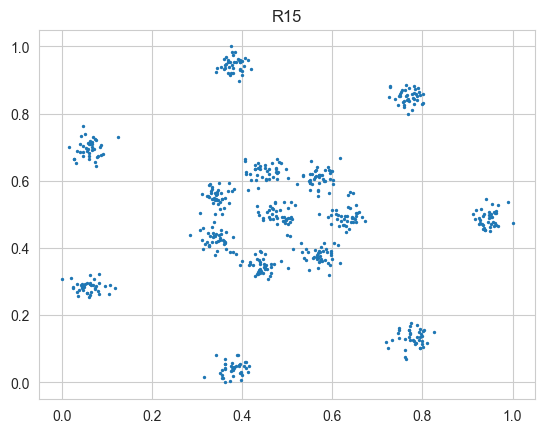

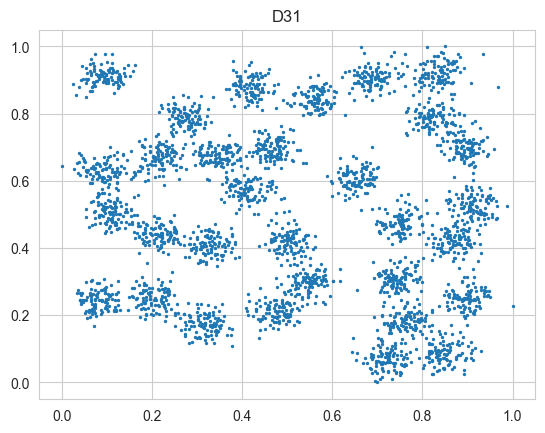

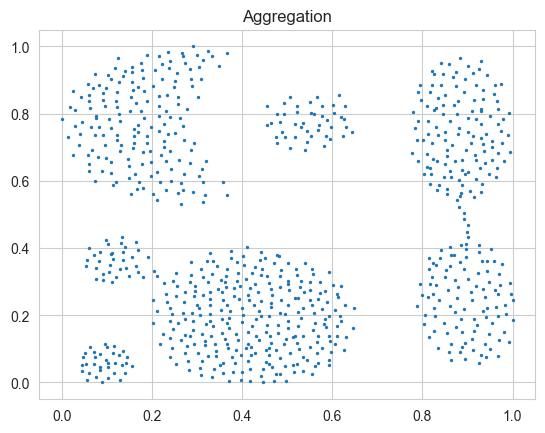

In [36]:
#手写DPC clustering
plt.scatter(df1[0],df1[1],s=2)
plt.title('R15')
plt.show()
plt.scatter(df2[0],df2[1],s=2)
plt.title('D31')
plt.show()
plt.scatter(df3[0],df3[1],s=2)
plt.title('Aggregation')
plt.show()

In [37]:
from numba import jit
@jit(nopython=True)
def Dist(df):
    dist=np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(len(df)):
            dist[i,j]=np.sqrt(np.sum(np.square(df[i,:]-df[j,:])))
    return dist

In [38]:
df_np=np.array(df1)
dist=Dist(df_np)

In [39]:
#计算密度rho
@jit(nopython=True)
def Rho(dist,intercept=0.02):
    rho=np.zeros(len(dist))
    for i in range(len(dist)):
        for j in range(len(dist)):
            if dist[i,j]<intercept:
                rho[i]+=1
    return rho

In [40]:
intercept=0.02
rho=Rho(dist,intercept=intercept)
rho

array([11., 11., 12.,  8.,  8.,  7., 13.,  5., 14.,  2.,  4.,  7.,  9.,
        5., 13.,  5., 13., 13.,  5.,  8.,  4.,  9.,  6.,  2.,  6.,  9.,
        3., 11.,  5., 10.,  8., 13., 13.,  9.,  3., 11.,  9.,  5., 13.,
        2., 10.,  9.,  9., 13., 12., 14.,  3.,  3.,  8., 10.,  1.,  3.,
       12.,  9., 10., 10.,  5.,  8.,  7.,  3.,  5.,  4., 10., 11.,  5.,
        3.,  2.,  2.,  3., 12.,  6., 10., 16.,  7., 14.,  9.,  9., 14.,
        4.,  3.,  7.,  9., 15.,  9., 13., 12., 14.,  1.,  8.,  4.,  6.,
       14., 11., 12.,  6.,  5.,  5., 14., 12., 12.,  1.,  7.,  4.,  4.,
       12., 13.,  7.,  4., 14.,  6.,  6.,  1.,  3.,  4., 13.,  6.,  7.,
       13.,  4.,  8.,  5.,  9.,  5.,  4.,  6.,  9.,  1.,  1.,  9.,  6.,
        8.,  1.,  2.,  9.,  8.,  8.,  9., 11.,  6.,  9.,  8.,  6.,  7.,
        1.,  9.,  9.,  4.,  9.,  7.,  2.,  5.,  7.,  7.,  7., 12.,  7.,
        3.,  4.,  3.,  1., 14., 13., 13., 15., 20., 10., 14.,  4.,  5.,
        4., 16., 15.,  5.,  9.,  3., 16.,  3., 15., 19., 19., 20

In [41]:
#计算相对距离,即计算密度比自己大的点到自己的最近距离
rel_dist=np.zeros((len(dist),2))
for i in range(len(rho)):
    #if 集合不空
    if dist[rho>rho[i],i].any(): 
        rel_dist[i,0]=np.min(dist[rho>rho[i],i])
        rel_dist[i,1]=np.where(dist[i,:]==rel_dist[i,0])[0][0]
    else:
        rel_dist[i,0]=np.max(dist[i,:])
        rel_dist[i,1]=np.where(dist[i,:]==rel_dist[i,0])[0][0]

In [42]:
rel_dist

array([[2.39513419e-02, 2.00000000e+00],
       [1.08075194e-02, 6.00000000e+00],
       [6.12326354e-03, 3.80000000e+01],
       ...,
       [2.26160095e-02, 5.68000000e+02],
       [7.44741818e-03, 5.62000000e+02],
       [8.53703687e-03, 5.64000000e+02]])

In [43]:
info=np.zeros((len(dist),2))
info[:,0]=rho.copy()
info[:,1]=rel_dist[:,0].copy()
#rename np.array columns
info_pd=pd.DataFrame(info,columns=['rho','rel_dist'])
info_pd.head()

,rho,rel_dist
0,11.0,0.023951
1,11.0,0.010808
2,12.0,0.006123
3,8.0,0.005217
4,8.0,0.004847


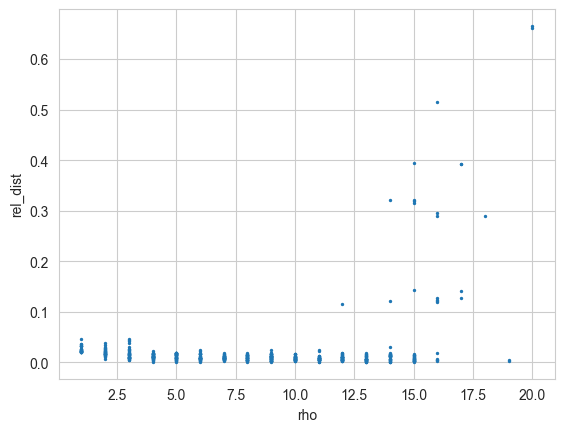

In [44]:
plt.scatter(info[:,0],info[:,1],s=2)
plt.xlabel('rho')
plt.ylabel('rel_dist')
plt.show()

In [45]:
#center_index=为密度大于5的且相对距离大于3的点
center_index=np.where((info[:,0]>=11)&(info[:,1]>=0.1))[0]
center_index

array([  8,  72,  82, 154, 164, 180, 210, 216, 226, 244, 247, 299, 351,
       368, 404, 446, 467, 496, 517, 521, 543, 587], dtype=int64)

In [46]:
df=df1.copy()
center_dist=np.zeros((df.shape[0],len(center_index)))
for i in range(df.shape[0]):
    for j in range(len(center_index)):
        center_dist[i,j]=dist[i,center_index[j]]
center_dist

array([[0.03415671, 0.16845024, 0.13890415, ..., 0.45881771, 0.4640318 ,
        0.48694927],
       [0.01476994, 0.12736579, 0.13974491, ..., 0.44128428, 0.44791633,
        0.44102785],
       [0.01281138, 0.14596695, 0.13407944, ..., 0.45251935, 0.45846663,
        0.4650017 ],
       ...,
       [0.41839267, 0.35286114, 0.4943217 , ..., 0.36506296, 0.3805076 ,
        0.04286413],
       [0.48532348, 0.41132048, 0.55441744, ..., 0.41209985, 0.42761709,
        0.03309354],
       [0.41450251, 0.33651504, 0.47973396, ..., 0.40020101, 0.41554957,
        0.04195752]])

In [47]:
cluster_index=np.zeros(df.shape[0])
for i in range(df.shape[0]):
    cluster_index[i]=center_dist[i,:].argmin()
cluster_index

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  2.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  4.,
        4.,  4.,  4.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5

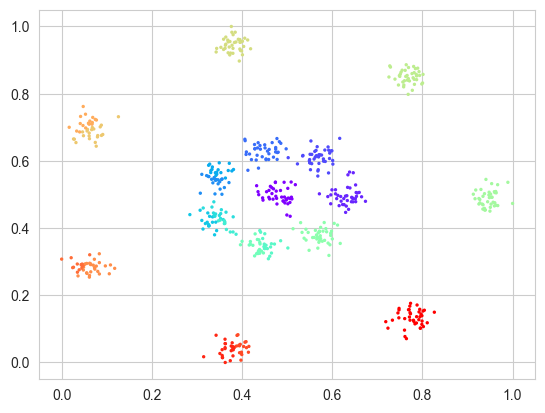

In [48]:
#画图
plt.scatter(df[0],df[1],c=cluster_index,s=2,cmap='rainbow')#cmap='rainbow'表示彩虹色,可选项有：
# 'viridis'，'plasma' 'inferno' 'magma' 'cividis'
plt.show()

In [49]:
import sklearn
from sklearn.metrics import davies_bouldin_score

In [50]:
davies_bouldin_score(df,cluster_index)
#dbi越小越好

0.8206765309899083

# DPC clustering
整合成函数

In [53]:
@jit(nopython=True)
def Dist(df):
    dist=np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(len(df)):
            dist[i,j]=np.sqrt(np.sum(np.square(df[i,:]-df[j,:])))
    return dist
@jit(nopython=True)
def Rho(dist,intercept=0.02):
    rho=np.zeros(len(dist))
    for i in range(len(dist)):
        for j in range(len(dist)):
            if dist[i,j]<intercept:
                rho[i]+=1
    return rho
def get_real_dist(dist,rho):
    rel_dist=np.zeros((len(dist),2))
    for i in range(len(rho)):
        #if 集合不空
        if dist[rho>rho[i],i].any(): 
            rel_dist[i,0]=np.min(dist[rho>rho[i],i])
            rel_dist[i,1]=np.where(dist[i,:]==rel_dist[i,0])[0][0]
        else:
            rel_dist[i,0]=np.max(dist[i,:])
            rel_dist[i,1]=np.where(dist[i,:]==rel_dist[i,0])[0][0]
    return rel_dist
def get_info_mat(rho,rel_dist):
    info=np.zeros((len(dist),2))
    info[:,0]=rho.copy()
    info[:,1]=rel_dist[:,0].copy()
    #rename np.array columns
    info_pd=pd.DataFrame(info,columns=['rho','rel_dist'])
    return info_pd
def plot_info(info):
    info=np.array(info)
    plt.scatter(info[:,0],info[:,1],s=2)
    plt.xlabel('rho')
    plt.ylabel('rel_dist')
    plt.show()
def get_center_index(info_pd,rho_threshold,rel_dist_threshold):
    center_index=np.where((info_pd['rho']>=rho_threshold)&(info_pd['rel_dist']>=rel_dist_threshold))[0]
    return center_index
def get_cluster_index(df,center_index,dist):
    center_dist=np.zeros((df.shape[0],len(center_index)))
    for i in range(df.shape[0]):
        for j in range(len(center_index)):
            center_dist[i,j]=dist[i,center_index[j]]
    cluster_index=np.zeros(df.shape[0])
    for i in range(df.shape[0]):
        cluster_index[i]=center_dist[i,:].argmin()
    return cluster_index
def plot_cluster(df,cluster_index):
    plt.scatter(df[0],df[1],c=cluster_index,s=2,cmap='rainbow')#cmap='rainbow'表示彩虹色,可选项有：
    # 'viridis'，'plasma' 'inferno' 'magma' 'cividis'
    plt.show()
def get_dbi(df,cluster_index):
    dbi=davies_bouldin_score(df,cluster_index)
    print(f'聚类的DBI index为={dbi}')

# R15数据集

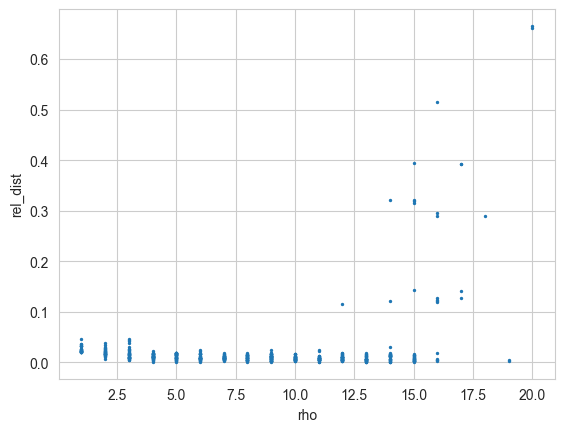

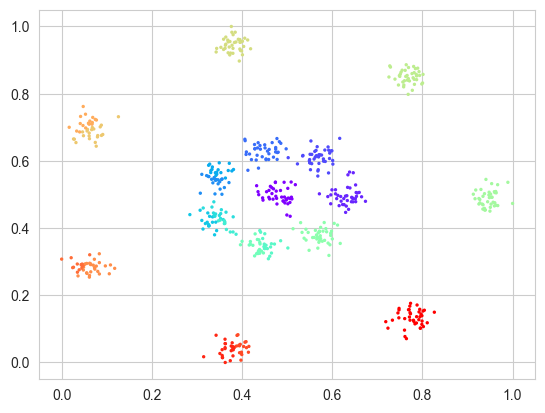

聚类的DBI index为=0.8206765309899083


In [55]:
df_np=np.array(df1)
dist=Dist(df_np)
rho=Rho(dist,intercept=intercept)
rel_dist=get_real_dist(dist,rho)
info_pd=get_info_mat(rho,rel_dist)
plot_info(info_pd)
center_index=get_center_index(info_pd,rho_threshold=11,rel_dist_threshold=0.1)
cluster_index=get_cluster_index(df1,center_index,dist)
plot_cluster(df1,cluster_index)
get_dbi(df1,cluster_index)

# D31数据集

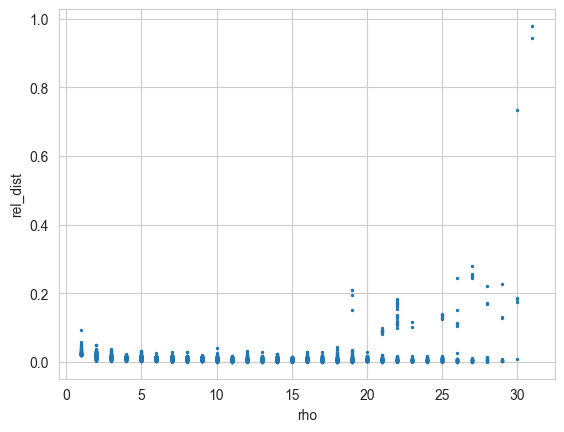

In [85]:
df=df2.copy()
df_np=np.array(df)
dist=Dist(df_np)
rho=Rho(dist,intercept=0.02)
rel_dist=get_real_dist(dist,rho)
info_pd=get_info_mat(rho,rel_dist)
plot_info(info_pd)

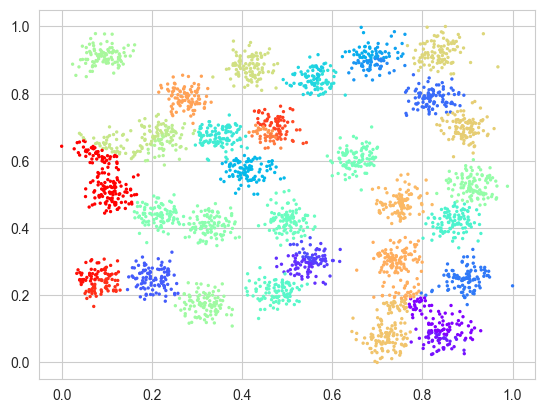

聚类的DBI index为=0.955500991703965


In [86]:
center_index=get_center_index(info_pd,rho_threshold=15,rel_dist_threshold=0.1)
cluster_index=get_cluster_index(df,center_index,dist)
plot_cluster(df,cluster_index)
get_dbi(df,cluster_index)

# Aggregation数据集

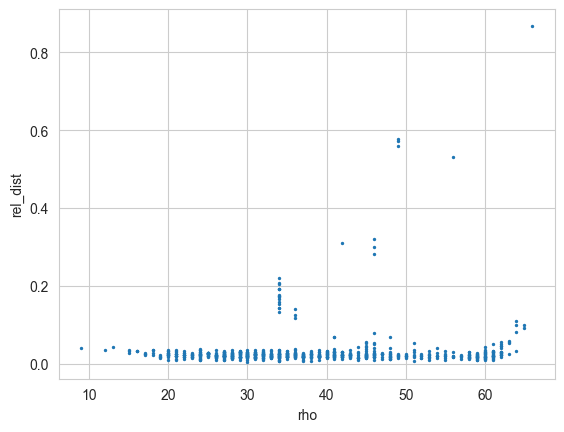

In [87]:
df=df3.copy()
df_np=np.array(df)
dist=Dist(df_np)
rho=Rho(dist,intercept=0.1)
rel_dist=get_real_dist(dist,rho)
info_pd=get_info_mat(rho,rel_dist)
plot_info(info_pd)

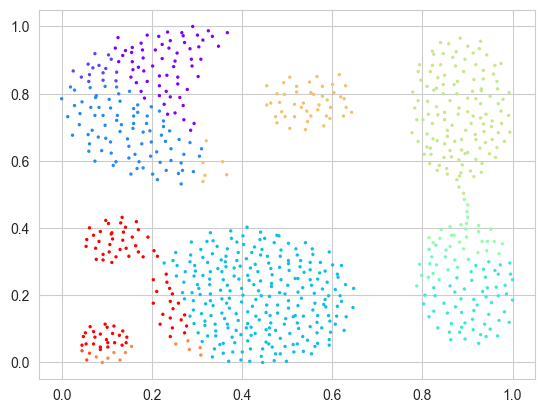

聚类的DBI index为=0.8547848699611479


In [88]:
center_index=get_center_index(info_pd,rho_threshold=13,rel_dist_threshold=0.2)
cluster_index=get_cluster_index(df,center_index,dist)
plot_cluster(df,cluster_index)
get_dbi(df,cluster_index)